In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
def construct_binary_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            ds.append((aptamer, peptide, 1))
            ds.append((get_x(), get_y(), 0))
    ds = list(set(ds)) #removed duplicates, random order
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

In [4]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_binary_dataset()
n = len(S)
m = int(0.8*n)
train = S[:m]
val = S[m:]

## NN Model

In [5]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 100) 
        self.fc_apt_2 = nn.Linear(100, 50)
        self.fc_apt_3 = nn.Linear(50, 10)
        
        self.fc_pep_1 = nn.Linear(160, 50)
        self.fc_pep_2 = nn.Linear(50, 10)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 50, 3) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3) 
        self.cnn_apt_4 = nn.Conv1d(25, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(30, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 500, 3) 
        self.cnn_apt_2 = nn.Conv1d(500, 250, 3)
        self.cnn_apt_3 = nn.Conv1d(250, 125, 3)
        self.cnn_apt_4 = nn.Conv1d(125, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3)
        self.cnn_pep_3 = nn.Conv1d(250, 50, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(100, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        #print("apt1: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        #print("apt2: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        #print("apt3: ", apt.size())
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        #print("apt4: ", apt.size()) (1, 50, 1)
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        #print("pep1: ", pep.size())
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        #print("pep2: ", pep.size())
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        #print("pep3: ", pep.size()) (1, 50, 1)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        #print("cat: ", x.size())
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3) 
        self.cnn_apt_2 = nn.Conv1d(1000, 800, 3)
        self.cnn_apt_3 = nn.Conv1d(800, 600, 3)
        self.cnn_apt_4 = nn.Conv1d(600, 400, 3)
        self.cnn_apt_5 = nn.Conv1d(400, 200, 1)
        self.cnn_apt_6 = nn.Conv1d(200, 100, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 1000, 3)
        self.cnn_pep_2 = nn.Conv1d(1000, 800, 1)
        self.cnn_pep_3 = nn.Conv1d(800, 500, 1)
        self.cnn_pep_4 = nn.Conv1d(500, 250, 1)
        self.cnn_pep_5 = nn.Conv1d(250, 100, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(200, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))
        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [10]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
    label = torch.FloatTensor([label]).to(device)
    return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)
    return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters[-1])
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/loss.png' %model_name, bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters[-1])
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/accuracy.png' %model_name, bbox_inches='tight')
    plt.show()

## Binary Classification

In [11]:
model = LinearNet()
model_name = model.name
checkpoint = None
save_path = 'model_checkpoints/binary/%s/05042020.pth' %model_name
model.apply(weights_init)
model.to(device)

def classifier(model, train, val, num_epochs=3, run_from_checkpoint=checkpoint, save_checkpoints=save_path):
    
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    model_name = model.name
    
    iters, train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], [], []
    i, train_correct, val_correct = 0, 0, 0
    for epoch in range(num_epochs):
        print("Starting epoch: %d" %epoch)
        for (apt, pep, label) in train:
            model.train()
            a, p, l = convert(apt, pep, label)
            train_score = update(a, p)
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            i += 1
            iters.append(i)
            train_loss = criterion(train_score, l) 
            train_losses.append(train_loss.item())
            train_loss.backward()               
            optimizer.step()              
            optimizer.zero_grad()
                
            if i % 1000 == 0:
                train_acc.append(100*train_correct/i)
                train_losses_avg.append(np.average(train_losses[-1000:]))

            with torch.no_grad():
                model.eval()
            a_val, p_val, l_val = convert(val[i%(n-m)][0], val[i%(n-m)][1], val[i%(n-m)][2])
            val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[i%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[i%(n-m)][2] == 0.0):
                val_correct += 1
            val_loss = criterion(val_score, l_val) 
            val_losses.append(val_loss.item())
            if i % 1000 == 0:
                val_acc.append(100*val_correct/i)
                val_losses_avg.append(np.average(val_losses[-1000:]))
            
            if i % 10000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name)
                plot_accuracy(iters, train_acc, val_acc, model_name)
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Starting epoch: 0


/home/yuhaowan/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


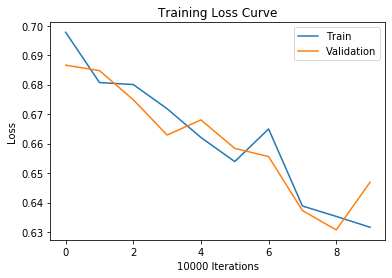

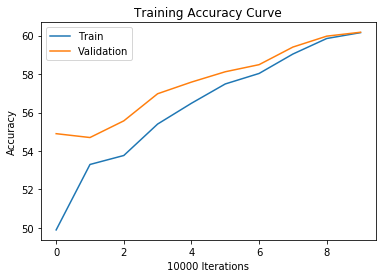

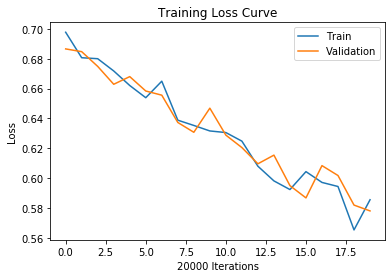

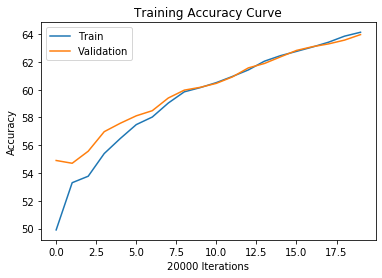

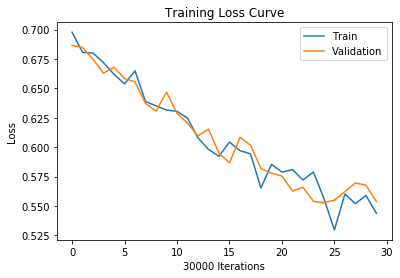

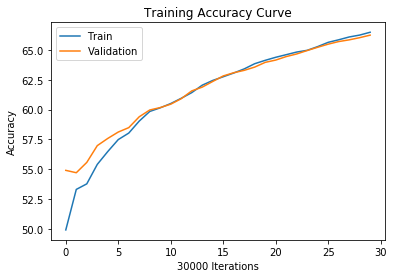

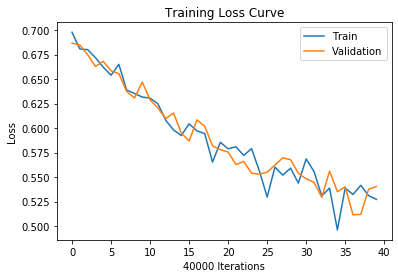

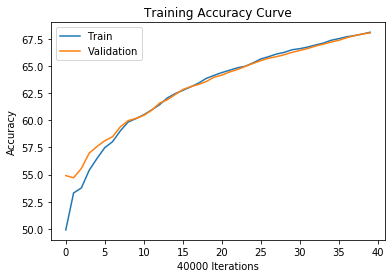

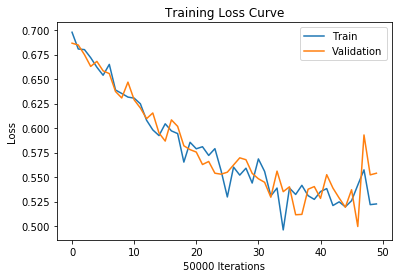

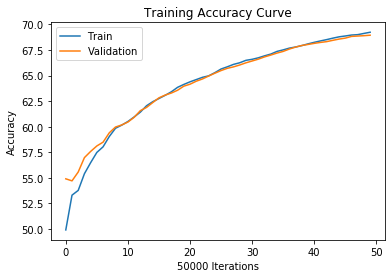

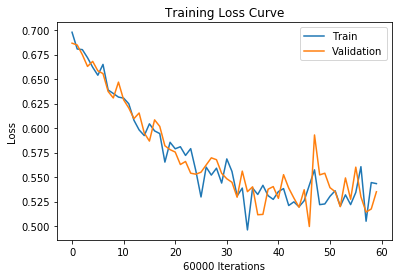

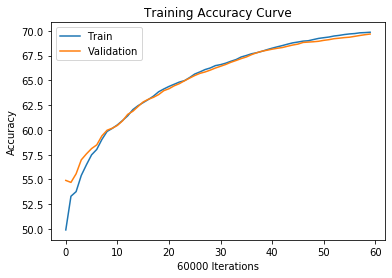

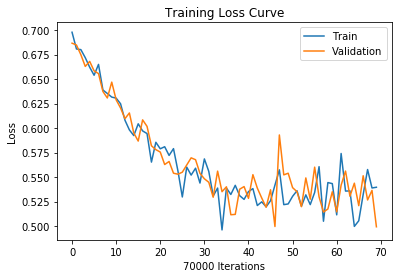

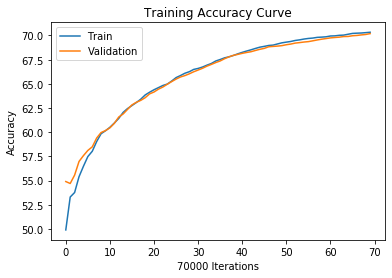

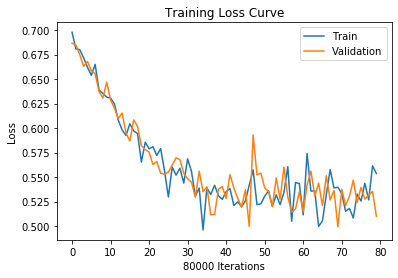

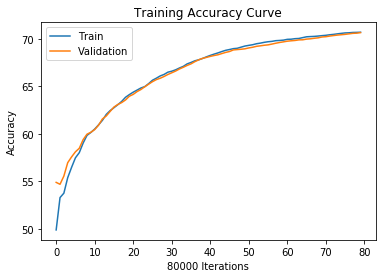

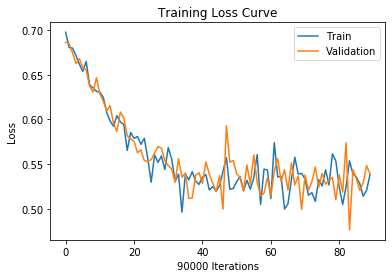

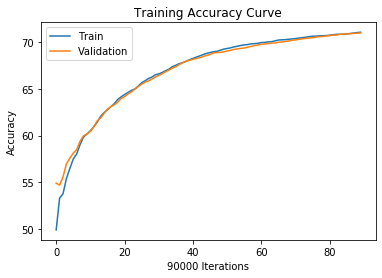

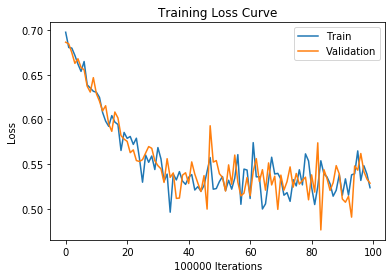

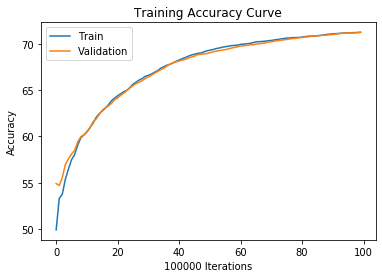

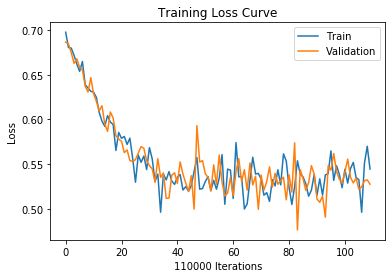

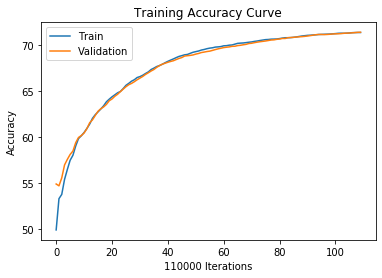

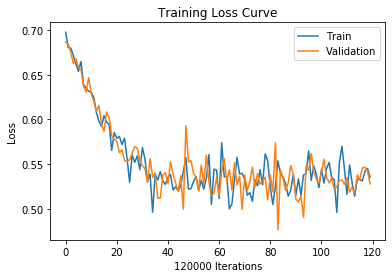

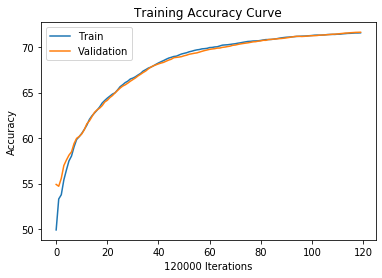

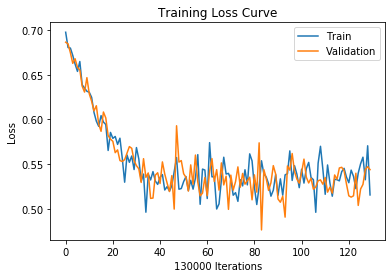

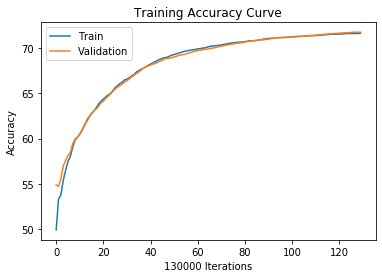

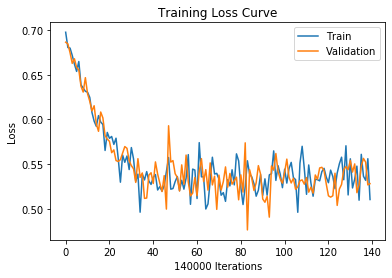

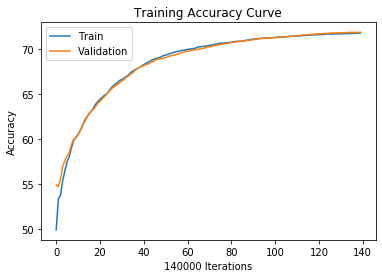

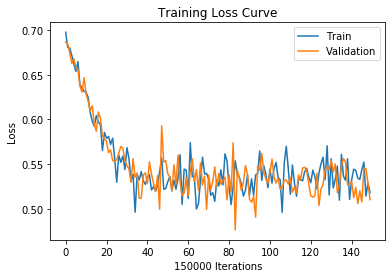

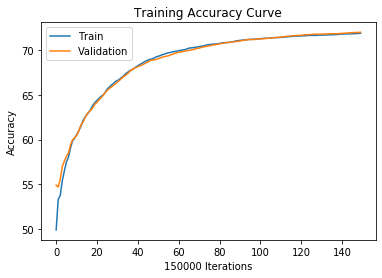

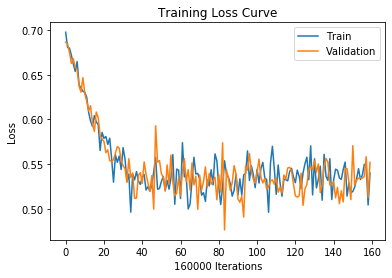

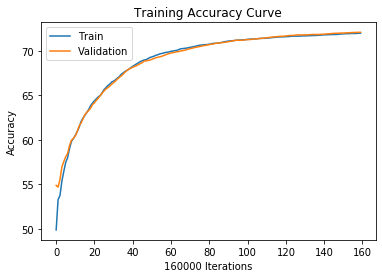

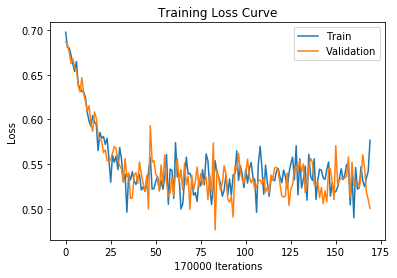

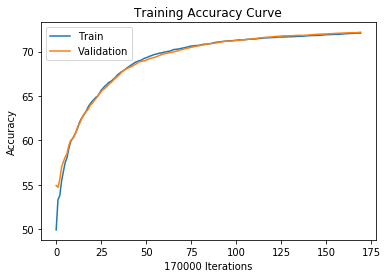

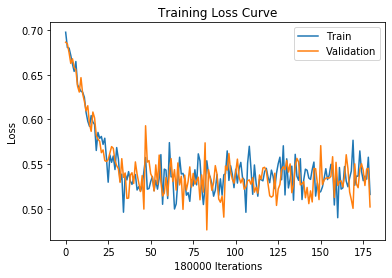

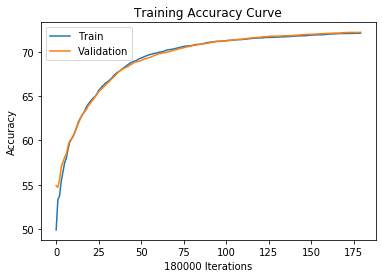

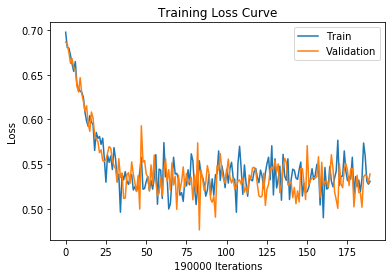

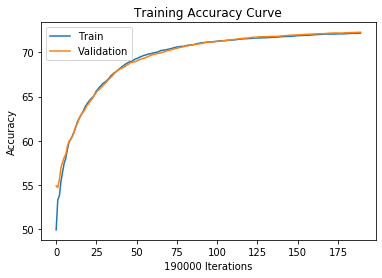

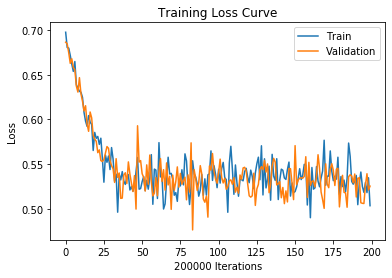

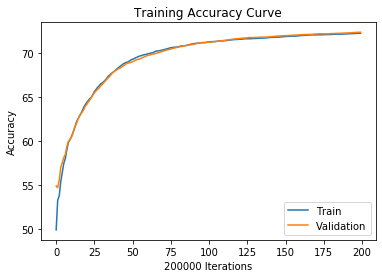

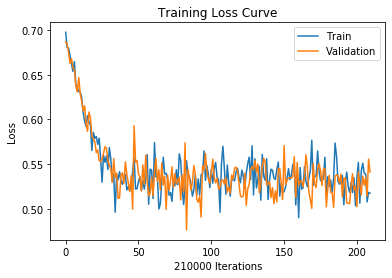

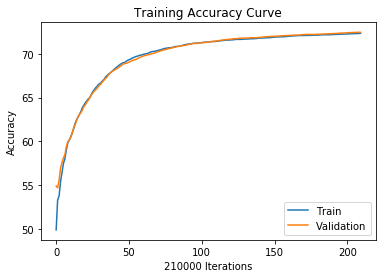

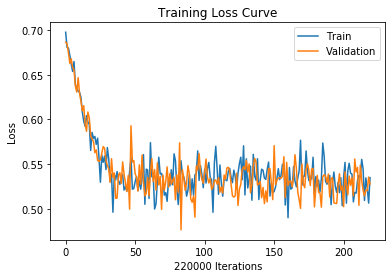

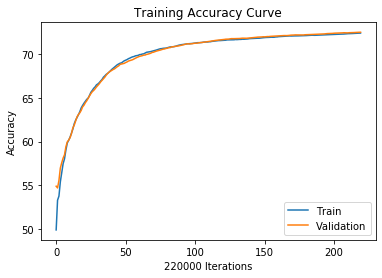

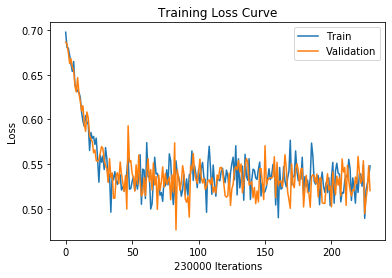

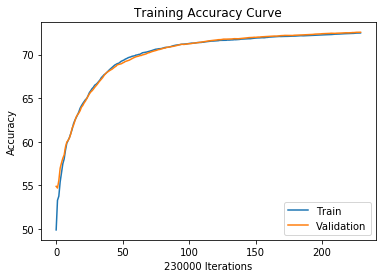

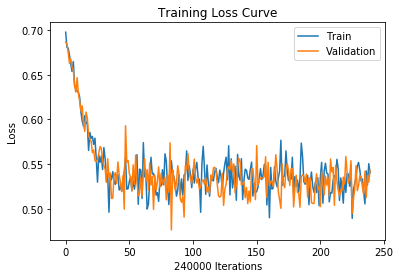

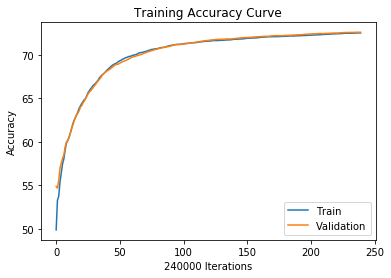

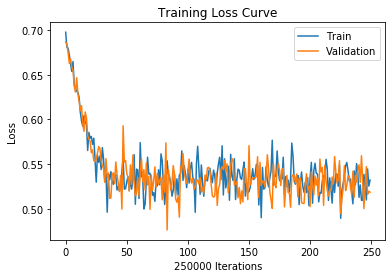

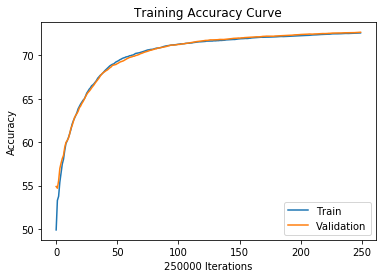

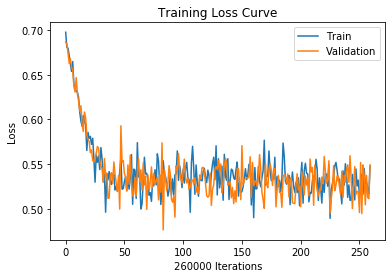

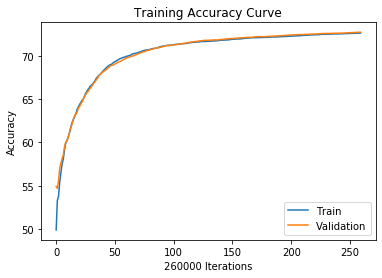

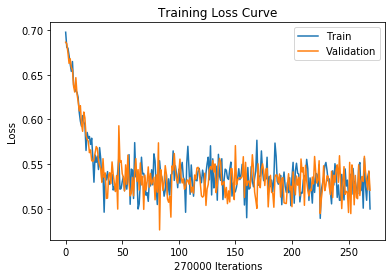

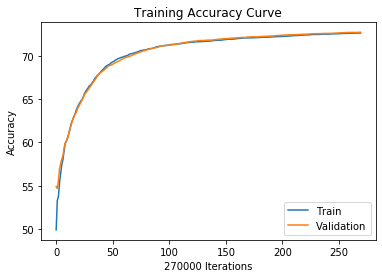

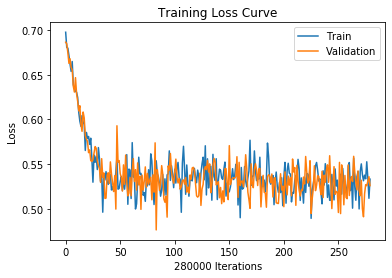

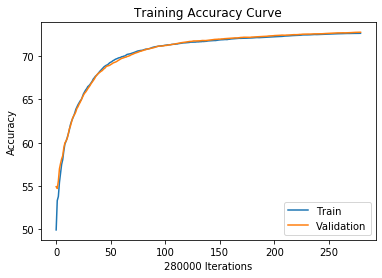

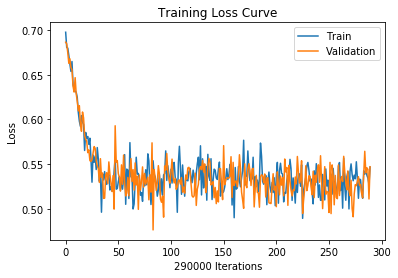

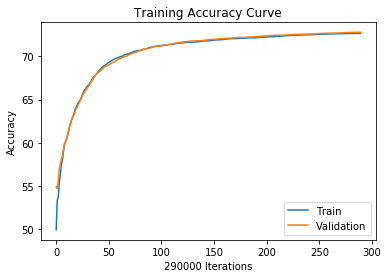

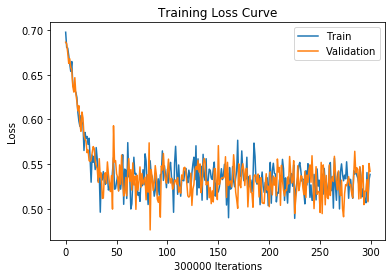

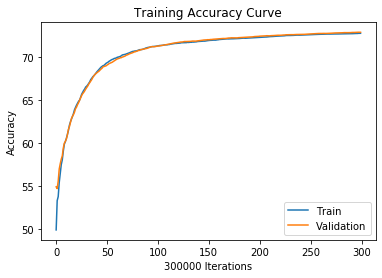

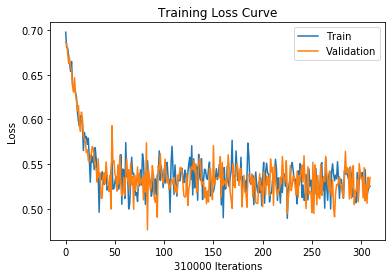

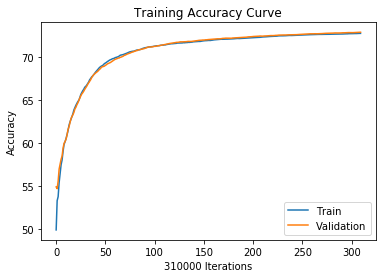

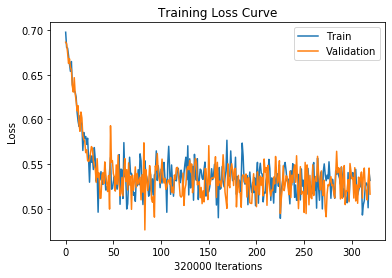

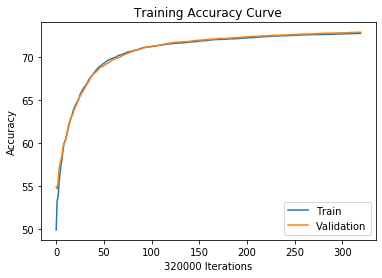

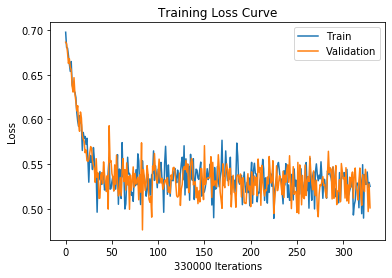

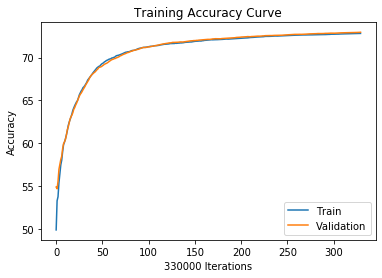

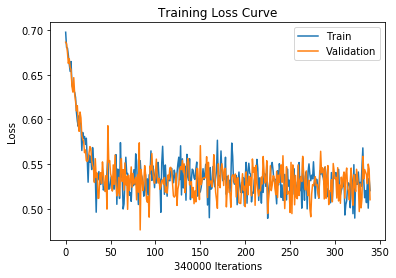

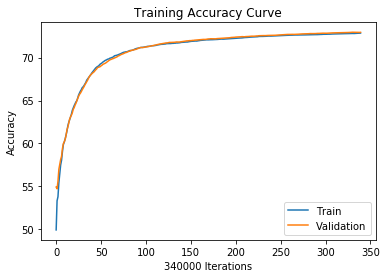

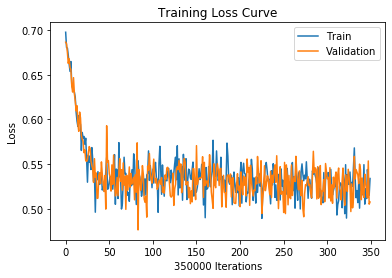

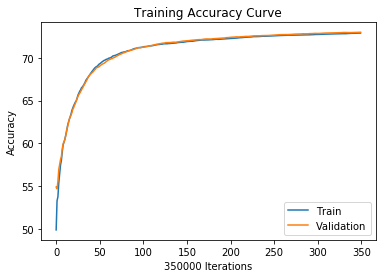

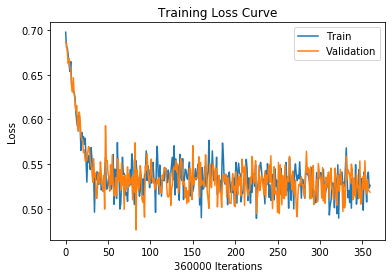

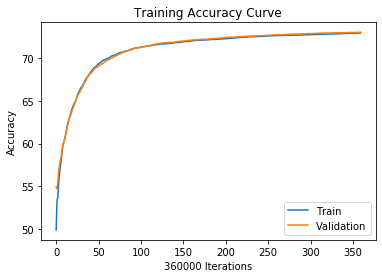

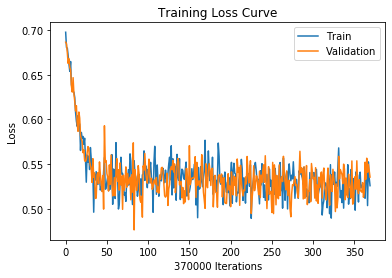

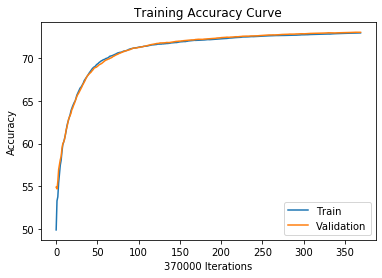

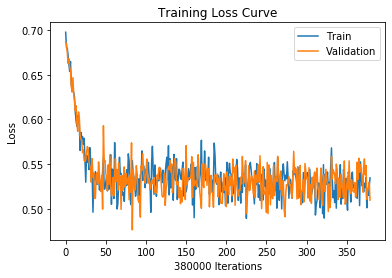

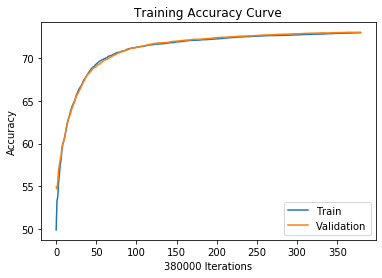

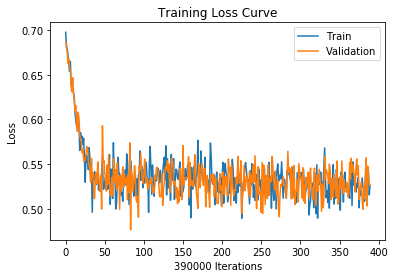

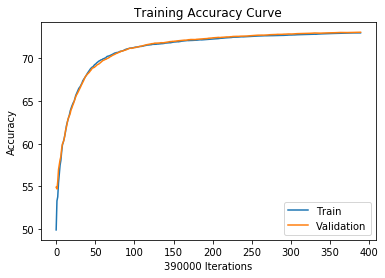

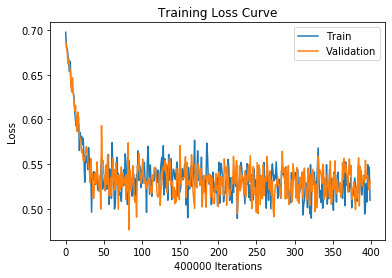

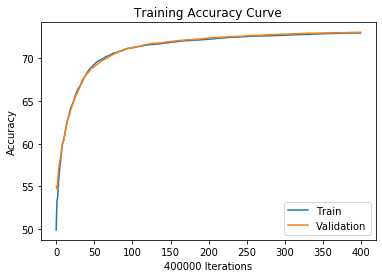

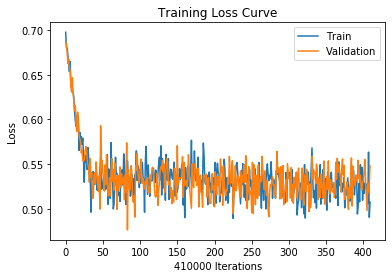

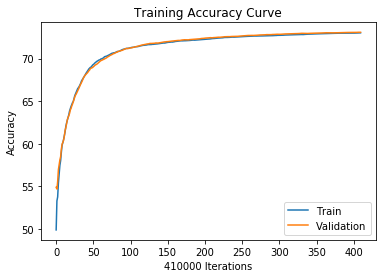

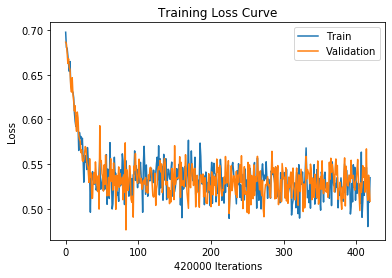

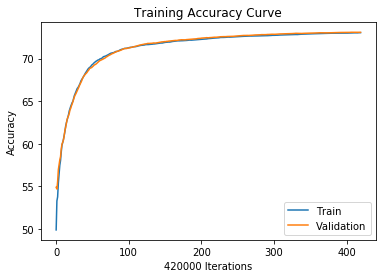

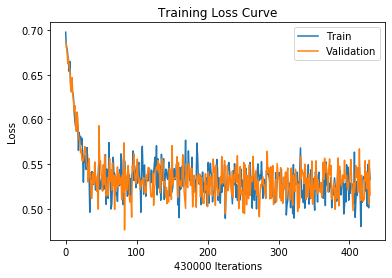

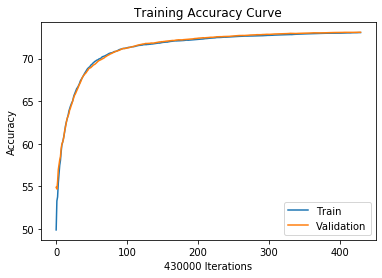

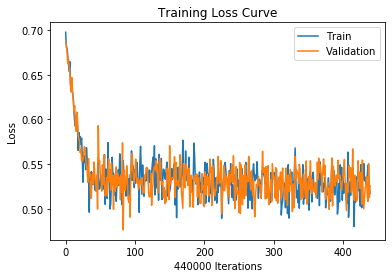

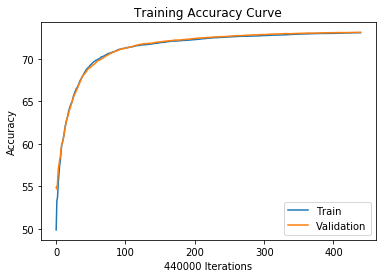

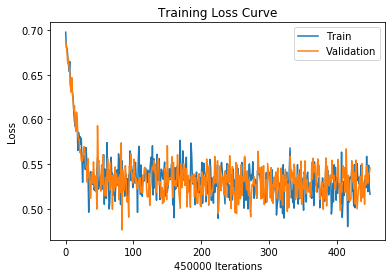

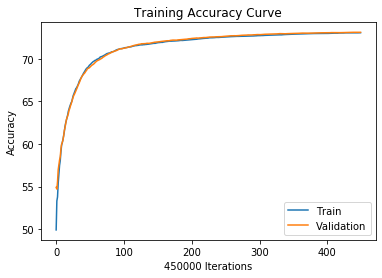

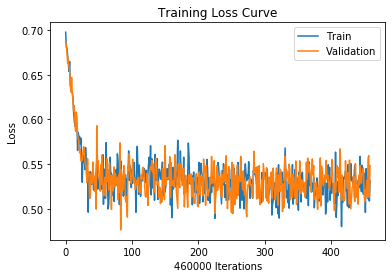

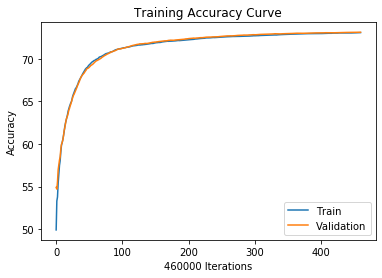

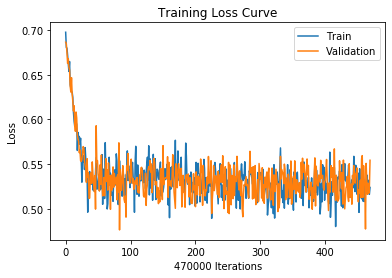

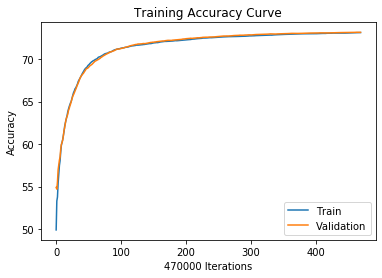

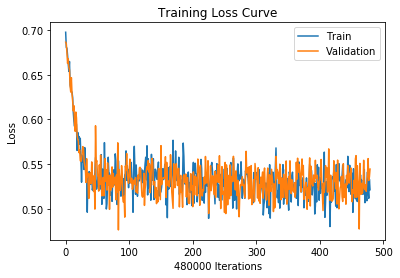

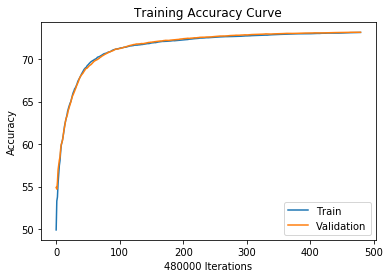

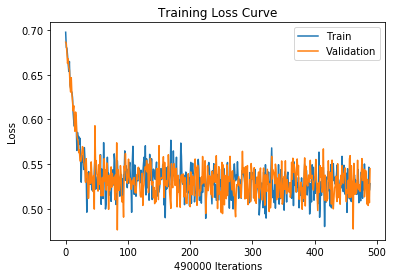

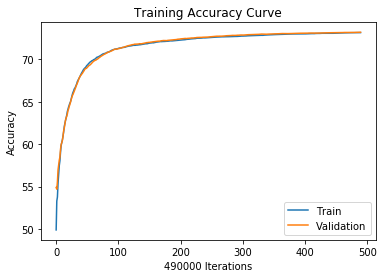

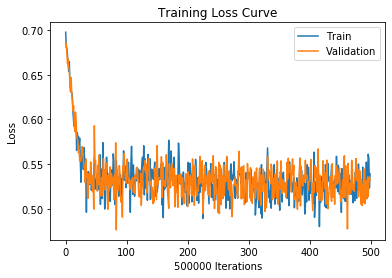

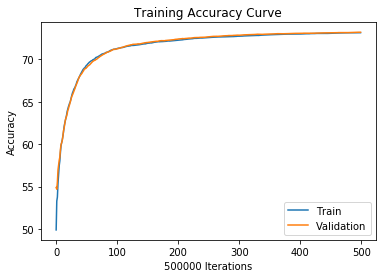

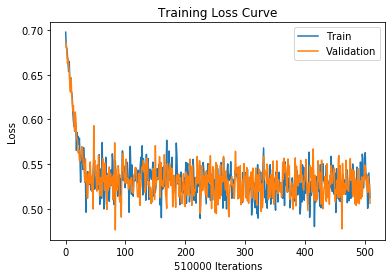

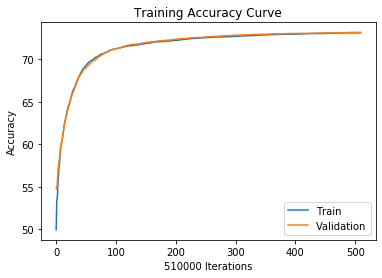

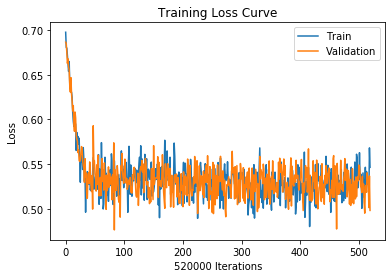

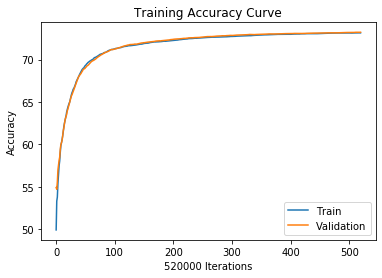

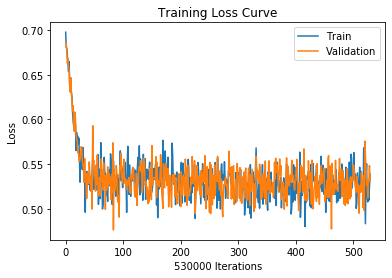

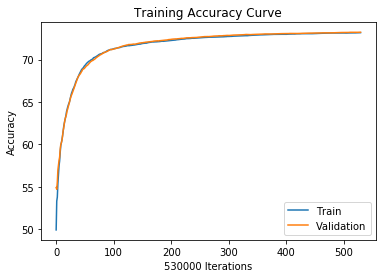

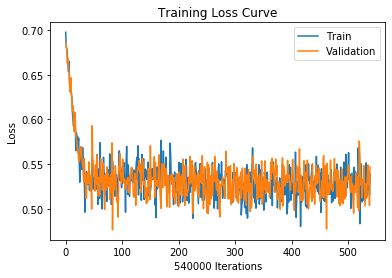

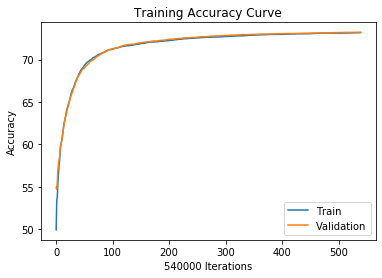

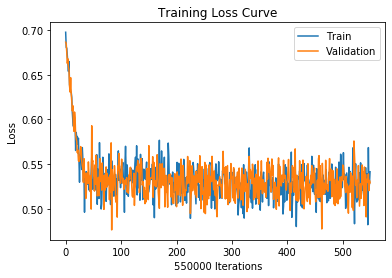

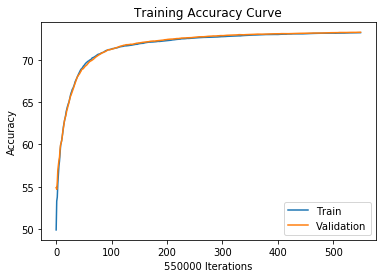

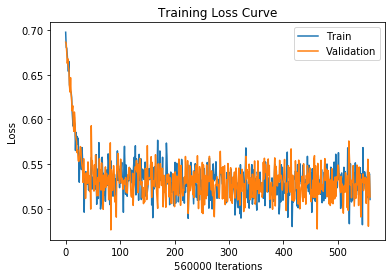

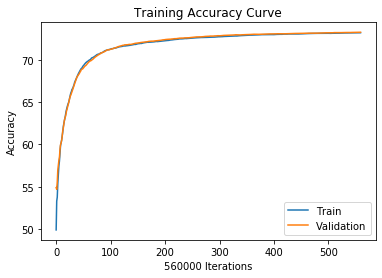

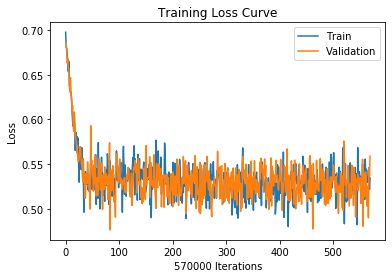

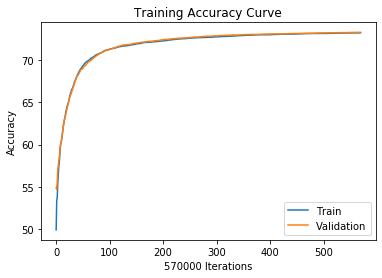

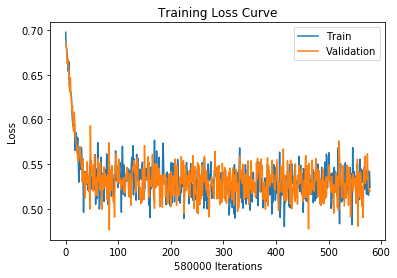

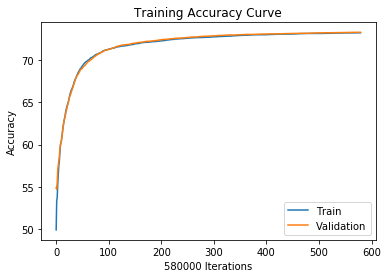

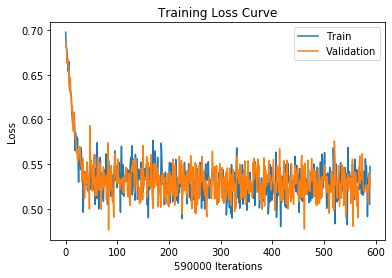

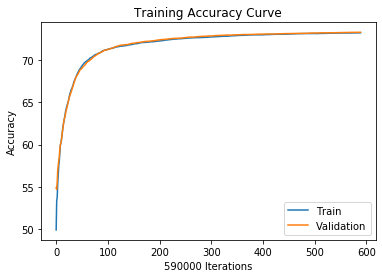

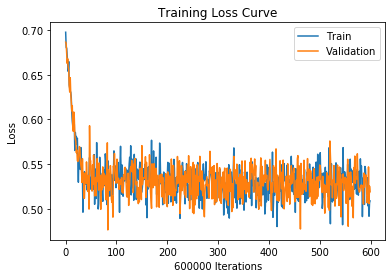

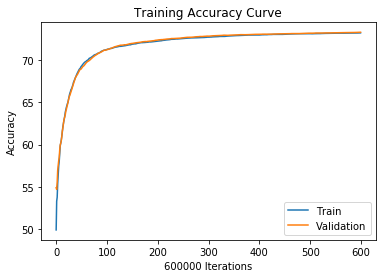

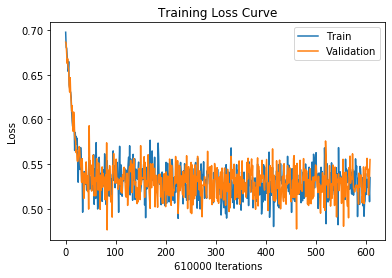

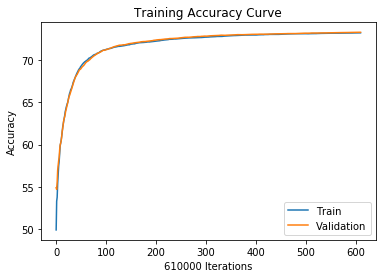

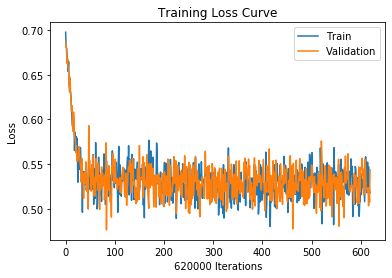

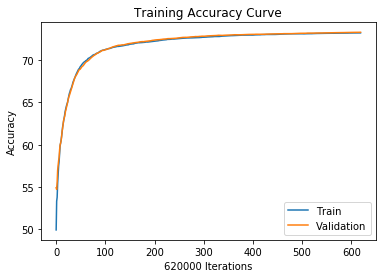

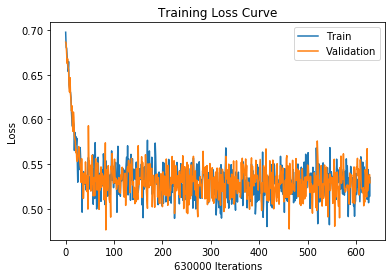

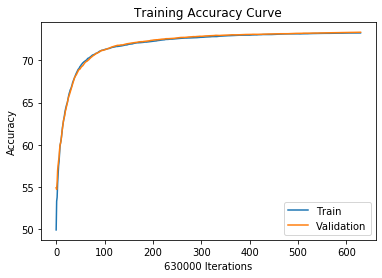

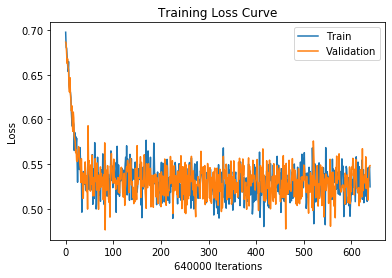

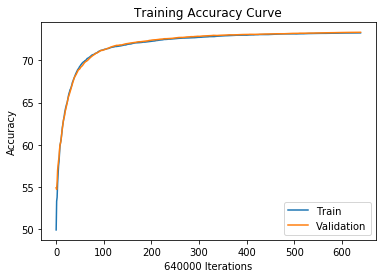

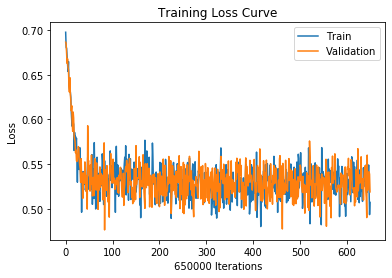

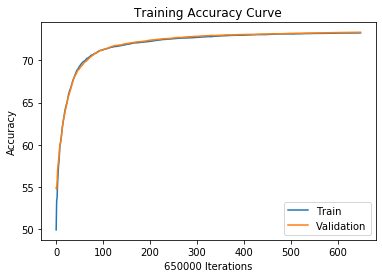

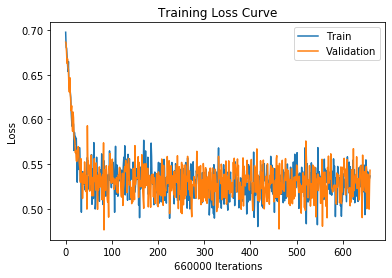

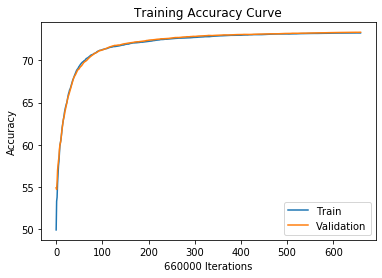

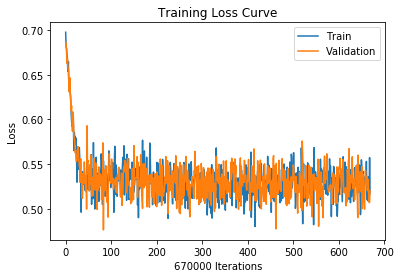

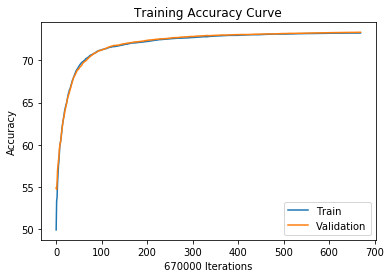

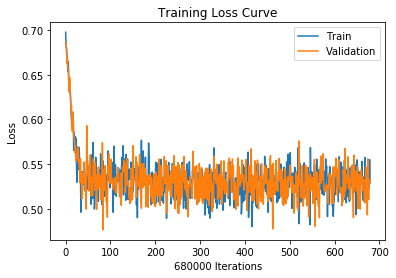

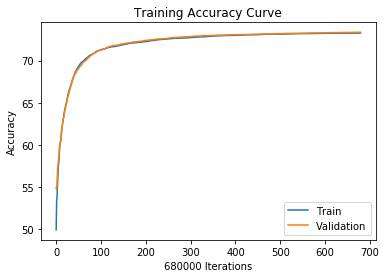

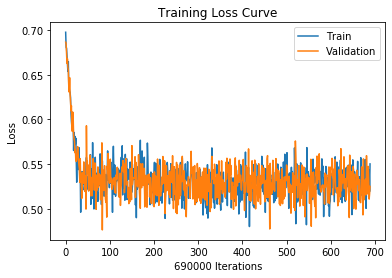

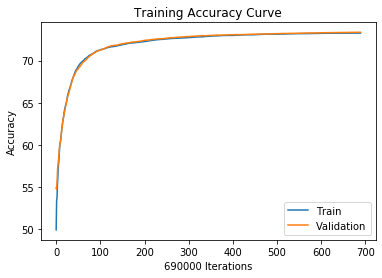

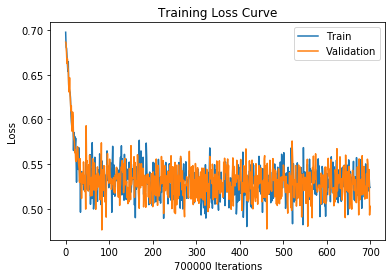

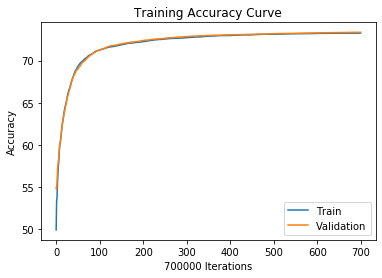

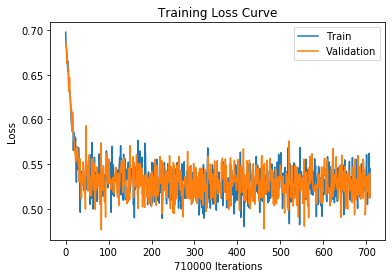

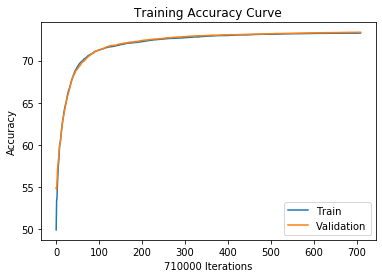

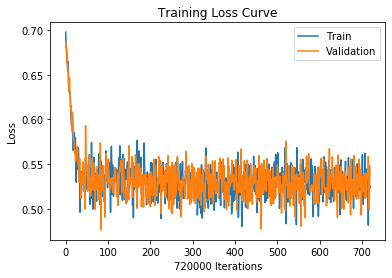

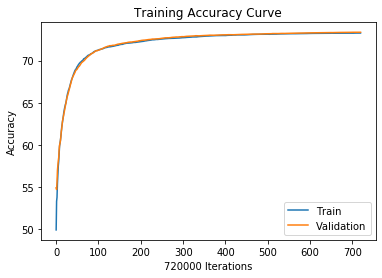

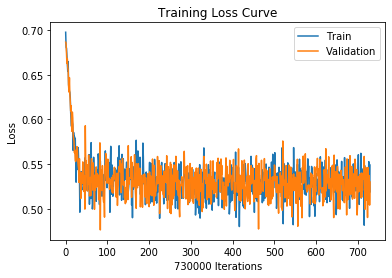

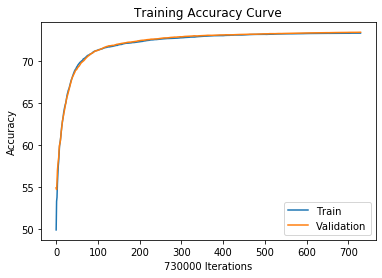

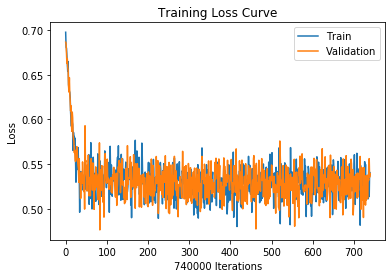

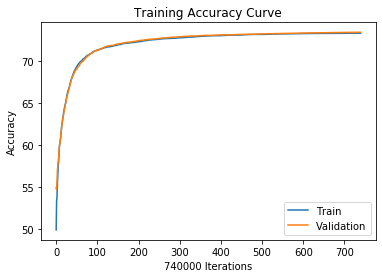

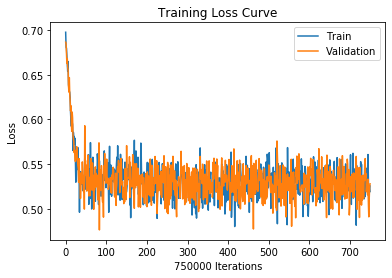

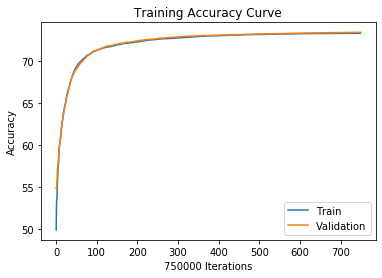

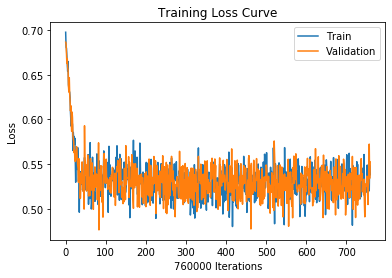

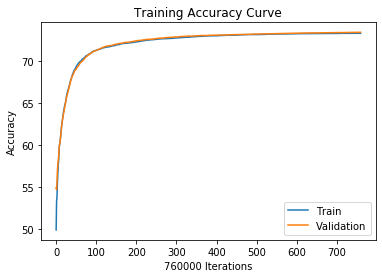

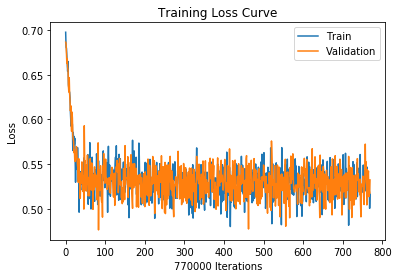

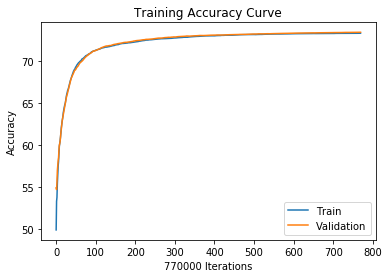

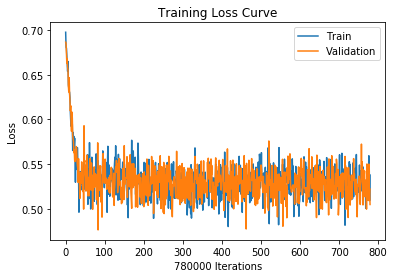

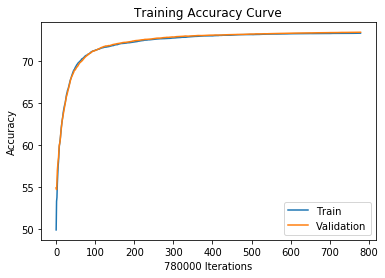

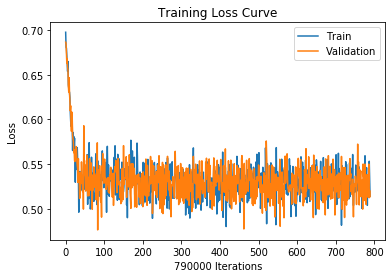

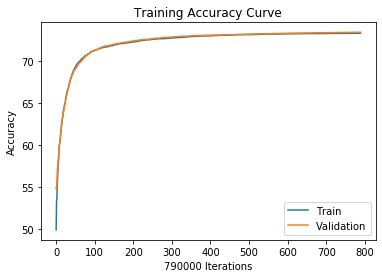

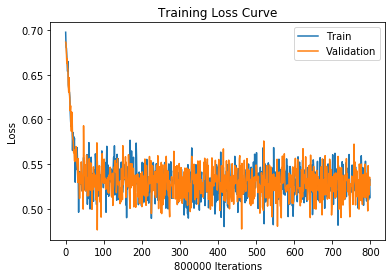

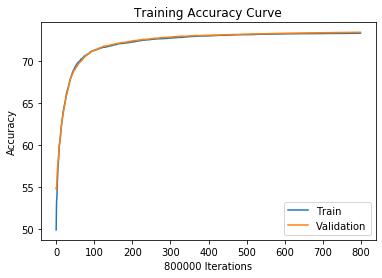

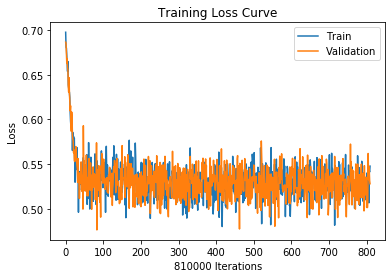

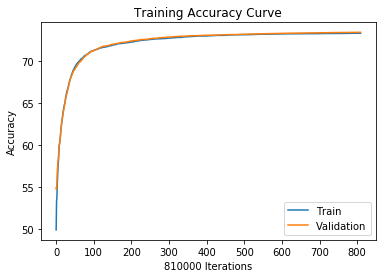

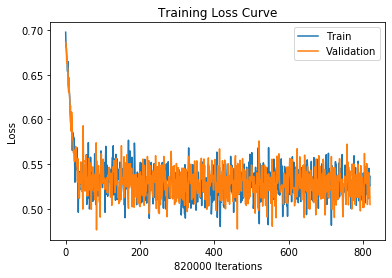

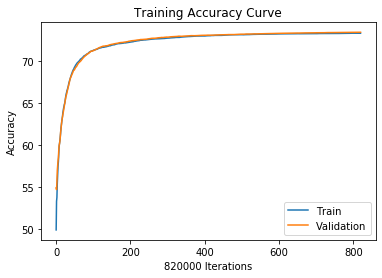

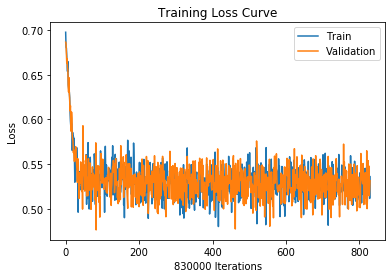

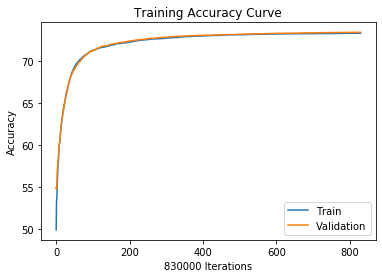

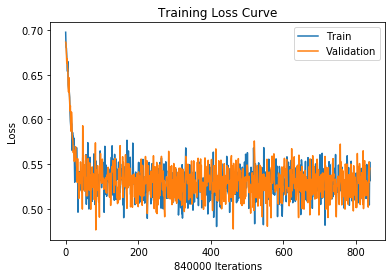

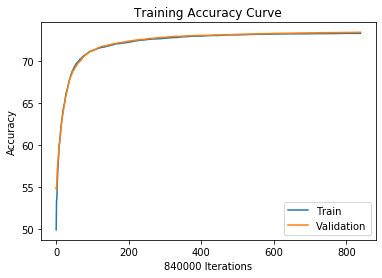

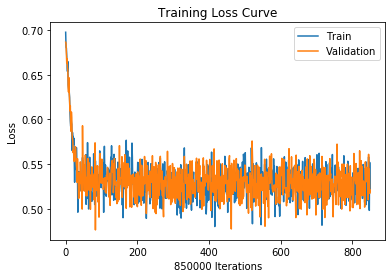

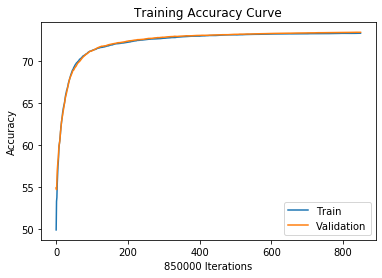

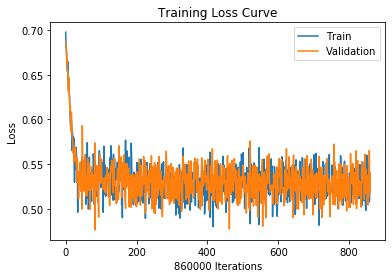

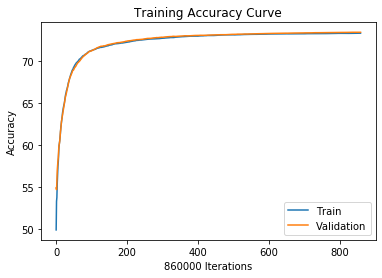

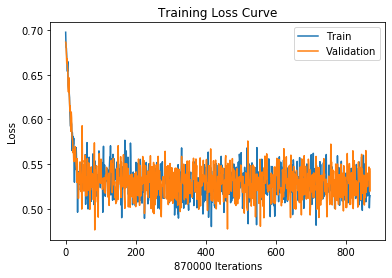

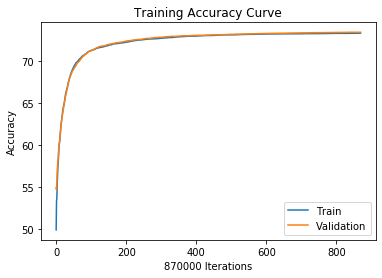

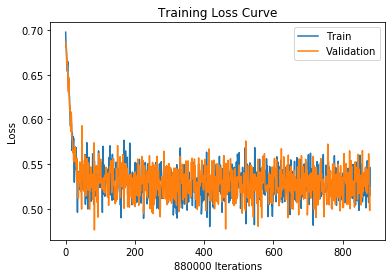

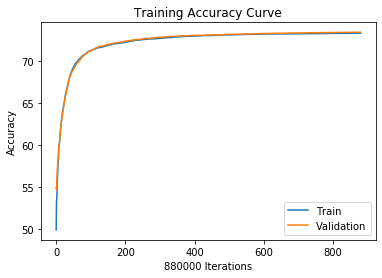

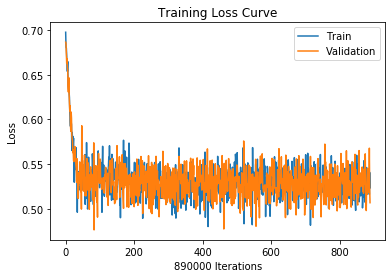

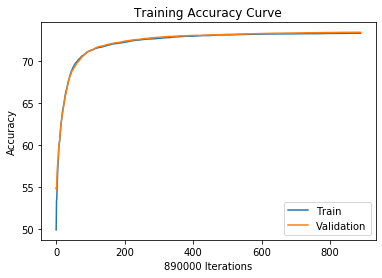

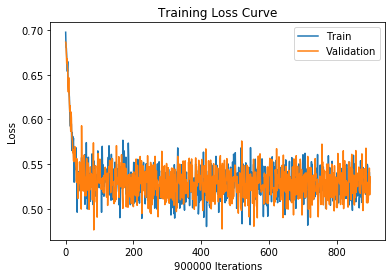

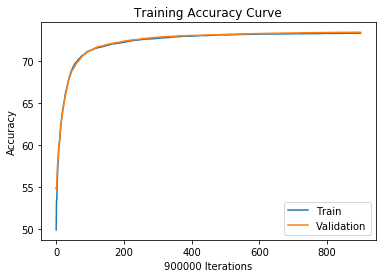

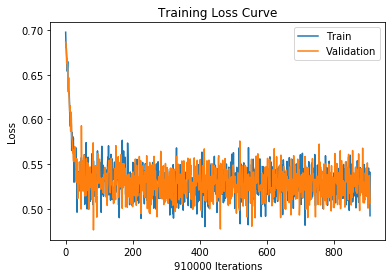

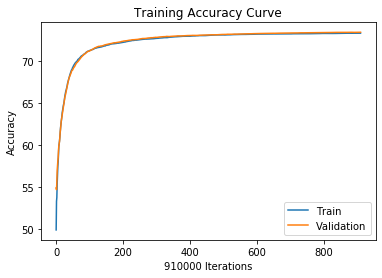

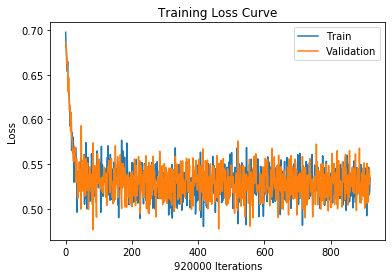

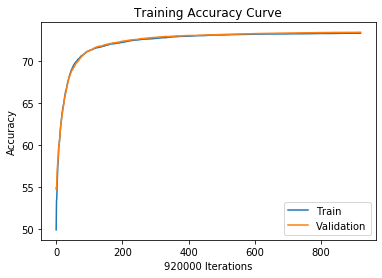

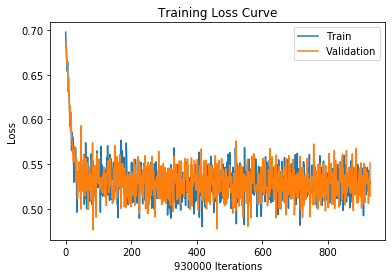

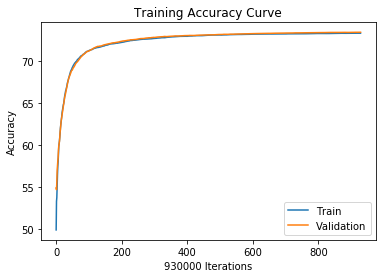

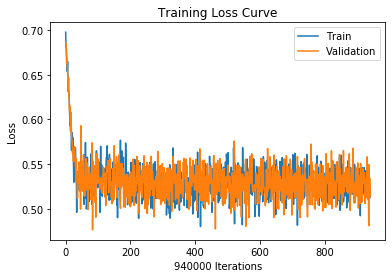

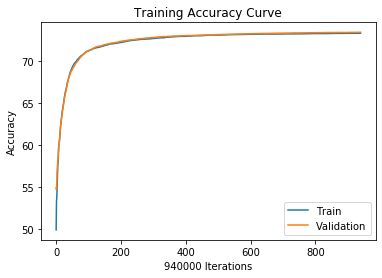

Saving to:  model_checkpoints/binary/LinearNet/05042020.pth
Starting epoch: 1


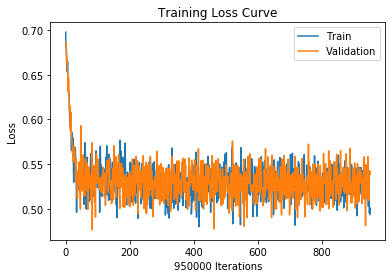

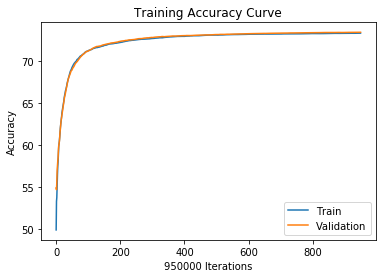

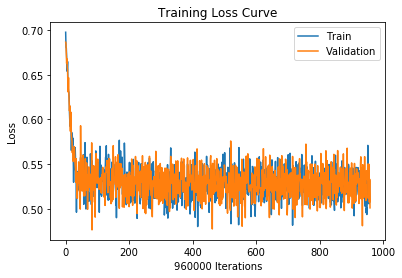

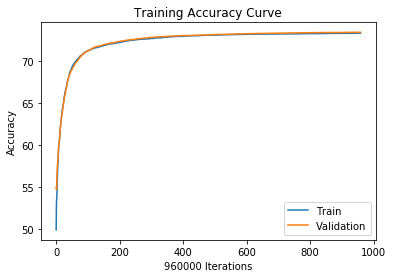

KeyboardInterrupt: 

In [12]:
classifier(model, train, val, 10, checkpoint, save_path)